In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import plotting_routines as pltrs

In [2]:
df_dir = "./pandas-dfs/"
df_filename = "fireyear-to-lat-long.pkl"
df = pd.read_pickle(df_dir+df_filename)
print(df.head()) # Ordered by Discovery Date

   FIRE_YEAR DISCOVERY_DATE  DISCOVERY_DOY DISCOVERY_TIME  \
0       1992       1/1/1992              1           0130   
1       1992       1/1/1992              1           1400   
2       1992       1/1/1992              1           2207   
3       1992       1/1/1992              1           1330   
4       1992       1/1/1992              1           1234   

  NWCG_CAUSE_CLASSIFICATION                       NWCG_GENERAL_CAUSE  \
0                   Natural                                  Natural   
1                     Human                  Debris and open burning   
2                     Human                Equipment and vehicle use   
3                     Human                  Debris and open burning   
4                     Human  Missing data/not specified/undetermined   

  NWCG_CAUSE_AGE_CATEGORY CONT_DOY CONT_TIME  FIRE_SIZE FIRE_SIZE_CLASS  \
0                                1      0210        0.1               A   
1                                1      2100      

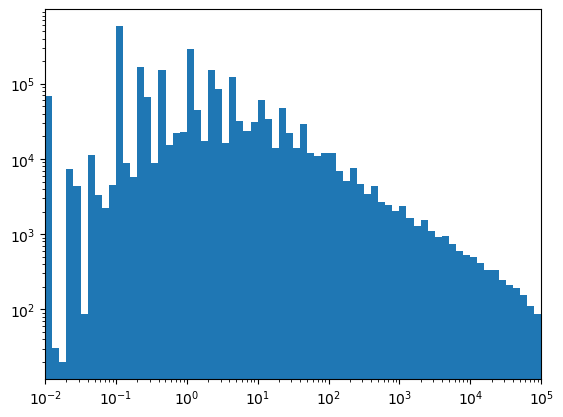

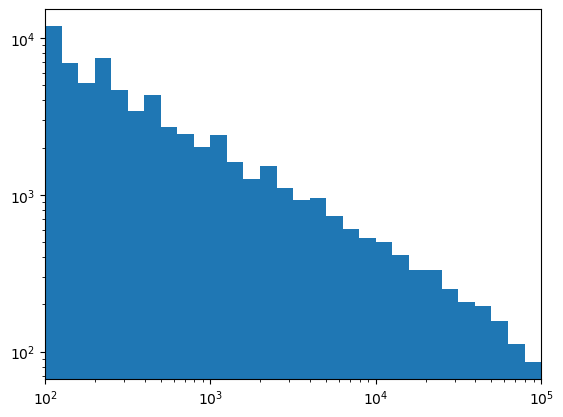

In [14]:
fig, ax = plt.subplots()

ax.hist(df['FIRE_SIZE'], bins=np.logspace(-2,5, 71))
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim([10**(-2),10**(5)])

plt.show()

df_lrg = df.loc[(df['FIRE_SIZE'] >= 100), ['NWCG_GENERAL_CAUSE','FIRE_YEAR','FIRE_SIZE',
                                           'DISCOVERY_TIME','FIRE_SIZE_CLASS',
                                          'LATITUDE', 'LONGITUDE']]

fig, ax = plt.subplots()

ax.hist(df_lrg['FIRE_SIZE'], bins=np.logspace(2,5, 31))
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim([10**(2),10**(5)])

plt.show()

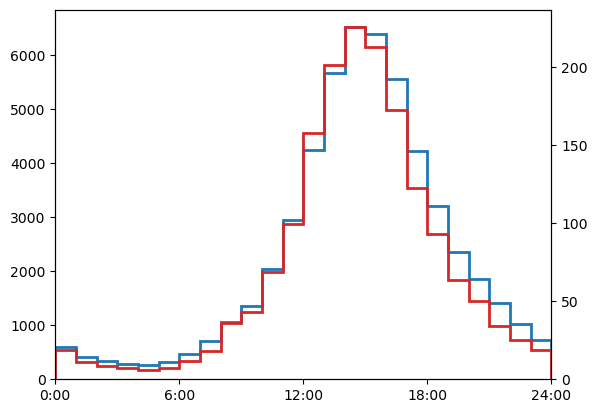

In [15]:
disctime = df['DISCOVERY_TIME'].replace('', np.nan).dropna().astype('int64')
disctime_lf = df_lrg['DISCOVERY_TIME'].replace('', np.nan).dropna().astype('int64')

fig, ax = plt.subplots()

norm = 28 # to get bin values in number of fires per year
hist, bin_edges = np.histogram(disctime, bins=np.linspace(0,2400,25))
ax.stairs(hist/norm, bin_edges, lw=2)
ax2=ax.twinx()

hist, bin_edges = np.histogram(disctime_lf, bins=np.linspace(0,2400,25))
ax2.stairs(hist/norm, bin_edges, lw=2, color='C3')

ax.set_xlim(0,2400)
ax.set_xticks([0,600,1200,1800,2400])
ax.set_xticklabels(["0:00","6:00","12:00","18:00","24:00"])

plt.show()

In [5]:
print(df_lrg['NWCG_GENERAL_CAUSE'].value_counts())

Natural                                       19579
Missing data/not specified/undetermined       15774
Arson/incendiarism                            10886
Debris and open burning                        8125
Equipment and vehicle use                      5700
Power generation/transmission/distribution     1428
Recreation and ceremony                        1296
Railroad operations and maintenance             980
Smoking                                         660
Fireworks                                       445
Misuse of fire by a minor                       391
Firearms and explosives use                     287
Other causes                                    123
Name: NWCG_GENERAL_CAUSE, dtype: int64


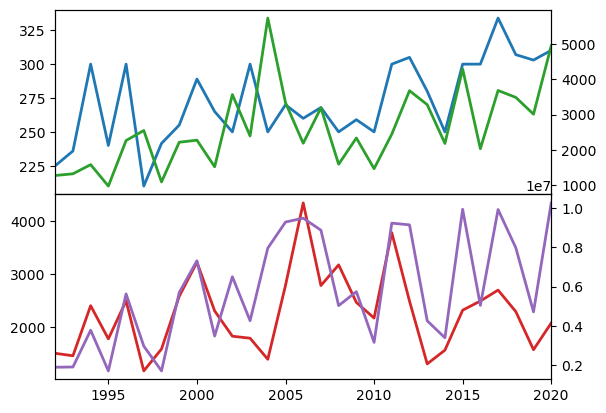

In [6]:
def compute_firesize_overtime(dataframe):
    #d = dataframe.loc[(dataframe['FIRE_SIZE'] >= 100), ['FIRE_YEAR','FIRE_SIZE','DISCOVERY_TIME']]
    median = dataframe.groupby(['FIRE_YEAR'])['FIRE_SIZE'].median()
    mean = dataframe.groupby(['FIRE_YEAR'])['FIRE_SIZE'].mean()
    summ = dataframe.groupby(['FIRE_YEAR'])['FIRE_SIZE'].sum()
    count = dataframe.groupby(['FIRE_YEAR'])['FIRE_SIZE'].count()
    return median, mean, summ, count

def plot_firesize_overtime(med, mean, summ, count):
    fig, axs = plt.subplots(2, 1, sharex=True)
    plt.subplots_adjust(hspace=0.0)

    ax = axs[0]

    ax.plot(med, lw=2)
    ax2=ax.twinx()
    ax2.plot(mean, color='C2', lw=2)
    ax.set_xlim([med.index.min(), med.index.max()])

    ax = axs[1]
    ax.plot(count,  color='C3', lw=2)
    ax2=ax.twinx()
    ax2.plot(summ, color='C4', lw=2)
    plt.show()
    
med_all, mean_all, sum_all, cnt_all = compute_firesize_overtime(df_lrg)
plot_firesize_overtime(med_all, mean_all, sum_all, cnt_all)

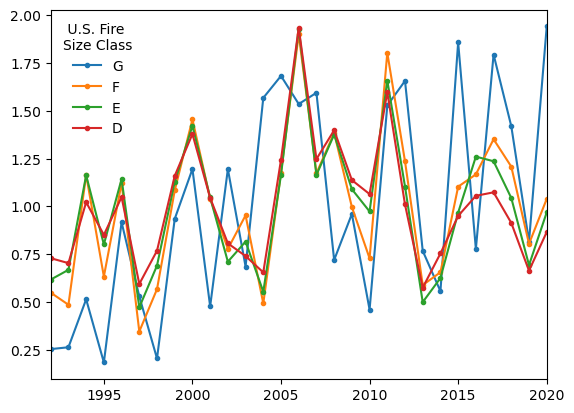

In [7]:
fig, ax = plt.subplots()

size_classes = sorted(df_lrg['FIRE_SIZE_CLASS'].unique()) # sorted alphabetically

for sc in np.flip(size_classes):
    df1 = df_lrg.loc[(df_lrg['FIRE_SIZE_CLASS'] == sc),['FIRE_YEAR', 'FIRE_SIZE']]
    sumfsize = df1.groupby(['FIRE_YEAR'])['FIRE_SIZE'].sum()#.to_numpy()
    #print(totfiresize)
    plt.plot(sumfsize/np.mean(sumfsize), '.-',
            label=sc)
    
ax.legend(title=" U.S. Fire\nSize Class",frameon=False)
ax.set_xlim([sumfsize.index.min(), sumfsize.index.max()])
#ax.set_xlim([year.min(), year.max()])
plt.show()

         FIRE_YEAR  FIRE_SIZE
874133        2017   662700.0
1877796       2012   558198.3
1319427       2011   538049.0
1412216       2004   537627.0
1474620       2009   517078.0
1630437       2002   499945.0
1856466       2004   483280.0
643004        2006   479549.0
1445525       2004   463994.0
2101843       2012   461047.0


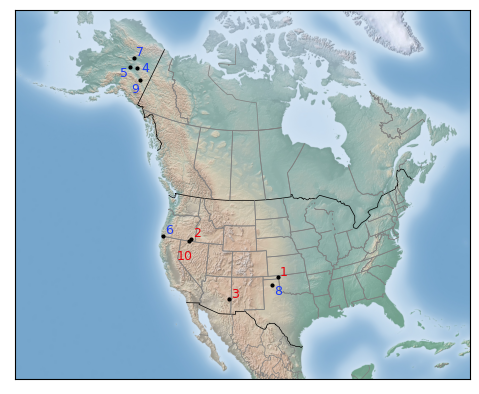

In [8]:
lrgfires_00_20 = df_lrg[(df_lrg['FIRE_YEAR'] >= 2000) & (df_lrg['FIRE_YEAR'] < 2020)]
lrgfires_00_20 = lrgfires_00_20.sort_values(by='FIRE_SIZE', ascending=False).head(n=10)

print(lrgfires_00_20[['FIRE_YEAR','FIRE_SIZE']])

fig, ax = plt.subplots()

m = Basemap(width=8000000,height=6500000,projection='lcc',
            resolution='l',lat_0=50,lon_0=-107.)
m.shadedrelief()
m.drawcountries()
m.drawstates(color='0.5')

x, y = m(lrgfires_00_20['LONGITUDE'], lrgfires_00_20['LATITUDE'])

ax.plot(x, y, 'ok', ms=2)

cnti = 0
for i in lrgfires_00_20.index:
    adjx = 0.0; adjy = 0.0;
      
    if(i == 1412216):   # 4
        adjx = 30000; adjy = -100000;
    elif(i == 1474620): # 5
        adjx = -200000; adjy = -200000;        
    elif(i == 643004):  # 8
        adjx = 0; adjy = -200000;
    elif(i == 1445525): # 9
        adjx = -200000; adjy = -250000;       
    elif(i == 2101843): # 10
        adjx = -250000; adjy = -350000;
        
    if(lrgfires_00_20.loc[i]['FIRE_YEAR'] < 2010):
        textclr = '#1e3bfa'
    else:
        textclr = '#e6020e'
               
    plt.text(x[cnti]+35000+adjx, y[cnti]+35000+adjy,
             str(cnti+1), color=textclr, fontsize=9)
    cnti += 1
plt.show()

In [9]:
# Create new dataframe based on latitude and longitude cuts

# Continental U.S.
conUS = df[(df['LATITUDE'] > 23) & (df['LATITUDE'] < 50) &
            (df['LONGITUDE'] > -130)]

# Alaska
AK = df[df['LATITUDE'] > 50]

conUS_00_10 = conUS[(conUS['FIRE_YEAR'] >= 2000) & (conUS['FIRE_YEAR'] < 2010)]
conUS_10_20 = conUS[(conUS['FIRE_YEAR'] >= 2010) & (conUS['FIRE_YEAR'] < 2020)]
conUS_00_20 = conUS[(conUS['FIRE_YEAR'] >= 2000) & (conUS['FIRE_YEAR'] < 2020)]

conUS = conUS.loc[(conUS['FIRE_SIZE'] >= 100), ['NWCG_GENERAL_CAUSE','FIRE_YEAR','FIRE_SIZE',
                                           'DISCOVERY_TIME','FIRE_SIZE_CLASS',
                                           'LONGITUDE','LATITUDE']]

AK_00_10 = AK[(AK['FIRE_YEAR'] >= 2000) & (AK['FIRE_YEAR'] < 2010)]
AK_10_20 = AK[(AK['FIRE_YEAR'] >= 2010) & (AK['FIRE_YEAR'] < 2020)]
AK_00_20 = AK[(AK['FIRE_YEAR'] >= 2000) & (AK['FIRE_YEAR'] < 2020)]

AK = AK.loc[(AK['FIRE_SIZE'] >= 100), ['NWCG_GENERAL_CAUSE','FIRE_YEAR','FIRE_SIZE',
                                           'DISCOVERY_TIME','FIRE_SIZE_CLASS',
                                           'LONGITUDE','LATITUDE']]

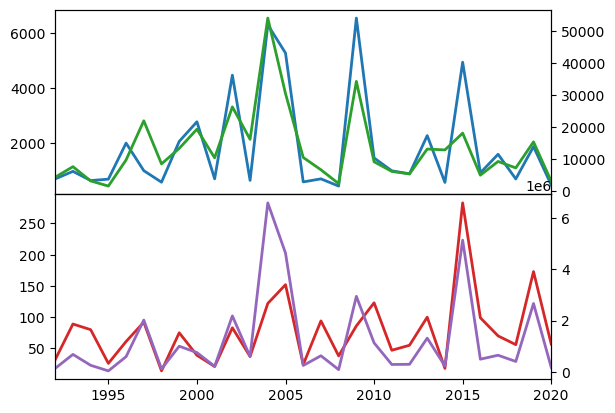

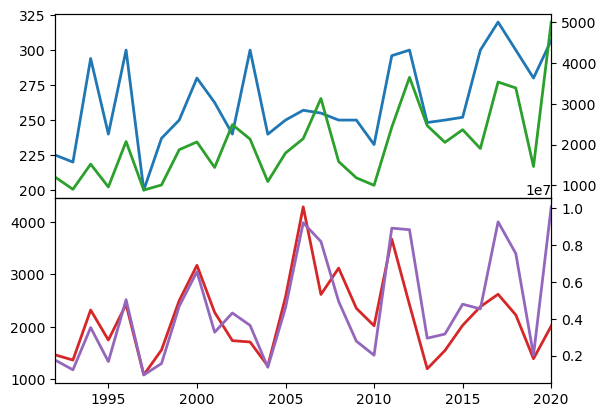

In [10]:
med_AK,  mean_AK,  sum_AK,  cnt_AK  = compute_firesize_overtime(AK)
med_cUS, mean_cUS, sum_cUS, cnt_cUS = compute_firesize_overtime(conUS)

plot_firesize_overtime(med_AK,  mean_AK,  sum_AK,  cnt_AK)
plot_firesize_overtime(med_cUS, mean_cUS, sum_cUS, cnt_cUS)

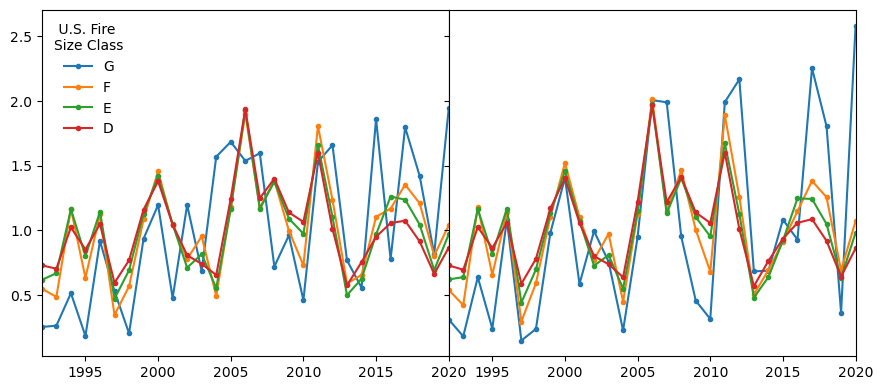

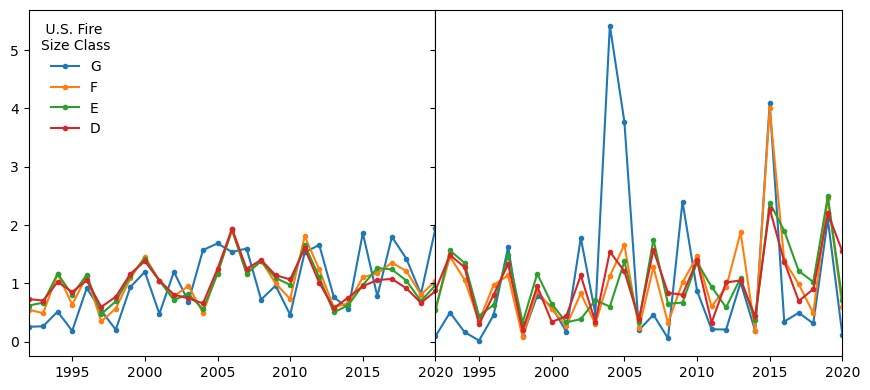

In [11]:
def plot_firesizeclass_2frame(subdf):
    fig, axs = plt.subplots(1,2, sharey=True, figsize=[10.5,4.5])
    plt.subplots_adjust(wspace=0.0)

    ax = axs[0]
    for sc in np.flip(size_classes):
        df1 = df_lrg.loc[(df_lrg['FIRE_SIZE_CLASS'] == sc),['FIRE_YEAR', 'FIRE_SIZE']]
        sumfsize = df1.groupby(['FIRE_YEAR'])['FIRE_SIZE'].sum()#.to_numpy()
        #print(totfiresize)
        ax.plot(sumfsize/np.mean(sumfsize), '.-',
                label=sc)
    ax.set_xlim([sumfsize.index.min(), sumfsize.index.max()])
    ax.legend(title=" U.S. Fire\nSize Class",frameon=False, loc='upper left')

    ax = axs[1]
    for sc in np.flip(size_classes):
        df1 = subdf.loc[(subdf['FIRE_SIZE_CLASS'] == sc),['FIRE_YEAR', 'FIRE_SIZE']]
        sumfsize = df1.groupby(['FIRE_YEAR'])['FIRE_SIZE'].sum()#.to_numpy()
        #print(totfiresize)
        ax.plot(sumfsize/np.mean(sumfsize), '.-',
                label=sc)
    ax.set_xlim([sumfsize.index.min(), sumfsize.index.max()])


plot_firesizeclass_2frame(conUS)
plot_firesizeclass_2frame(AK)

Hex and Area ratios:
Land Area: 4.704 ; Con. US.: 1.000 ; Alaska(1): 4.433; Alaska(2): 4.394


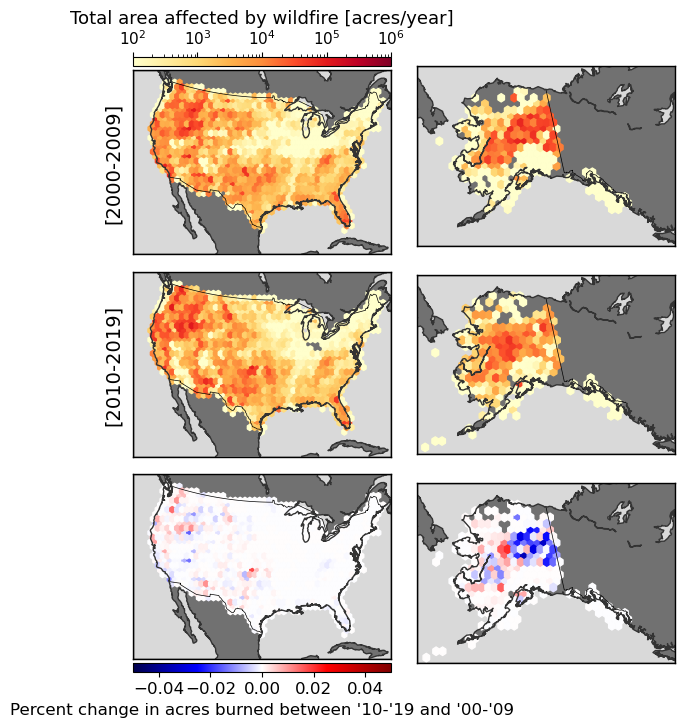

In [12]:
# lat & long pairs for the lower left and upper right corners, respectively
cUS_corners = [-120, 18, -62, 50];
AK_corners = [-170, 52, -105, 65]

# centering lat. and long.
cUS_ll0 = [40, -95]
AK_ll0 = [62.5, -155]

# gridsize argument to hexbin for each data set
# Manually adjusted until land per hex is roughly equal in each
# map, see prints at the bottom of the cell
cUS_hexgrid = [48,16]; AK_hexgrid = [40,12]; AK_hexgrid2 = [29,12];
cblimits = [100,1000000]
cblimits_diff = [-0.05, 0.05]

fig, axs = plt.subplots(3,2, figsize=[7,8])
plt.subplots_adjust(wspace = 0.1, hspace=0.05)

bColourbar = True
plt.axes(axs[0,0])
norm = 10 # normalization: 10 years and 1000,to get data as 1000's of acres per annum.
hex_cUS_00_10 = pltrs.plot_hexbin_frame( conUS_00_10, norm,
    cUS_corners, cUS_ll0, cUS_hexgrid,
    bColourbar, cblimits)
plt.ylabel('[2000-2009]', fontsize=14)

bColourbar = False
plt.axes(axs[0,1])
hex_AK_00_10 = pltrs.plot_hexbin_frame( AK_00_10, norm,
    AK_corners, AK_ll0, AK_hexgrid,
    bColourbar, cblimits)

"""
# Check that the sum of hexbin 2D histogram values equals
# the sum of the FIRE_SIZE from the raw data
# From this print I caught that the default function hexbin()
# uses to ammalgamate given colour values is mean, not sum!
print("sum check:", AK_00_10['FIRE_SIZE'].sum()/norm,
      np.sum(hex_AK_00_10.get_array()))
"""

plt.axes(axs[1,0])
hex_cUS_10_20 = pltrs.plot_hexbin_frame( conUS_10_20, norm,
    cUS_corners, cUS_ll0, cUS_hexgrid,
    bColourbar, cblimits)
plt.ylabel('[2010-2019]', fontsize=14)

plt.axes(axs[1,1])
hex_AK_10_20 = pltrs.plot_hexbin_frame( AK_10_20, norm,
    AK_corners, AK_ll0, AK_hexgrid2,
    bColourbar, cblimits)

bColourbar = True
plt.axes(axs[2,0])

norm = conUS_00_10['FIRE_SIZE'].sum()
#norm = 20*np.sum(hex_cUS_00_10.get_array())
# 20 years, and then the sum of all fires from '00-'09, to get % change
hdiff_cUS = pltrs.plot_hexbin_frame_diff( conUS_00_20, norm,
    cUS_corners, cUS_ll0, cUS_hexgrid,
    bColourbar, cblimits_diff)

bColourbar = False
plt.axes(axs[2,1])
norm = AK_00_10['FIRE_SIZE'].sum()
hdiff_AK = pltrs.plot_hexbin_frame_diff( AK_00_20, norm,
    AK_corners, AK_ll0, AK_hexgrid,
    bColourbar, cblimits_diff)


AK_area = 0.663 # Million sq. mi.
cUS_area = 3.119 # Million sq. mi.
print("Hex and Area ratios:")
print("Land Area: {:.3f} ; Con. US.: {:.3f} ; Alaska(1): {:.3f}; Alaska(2): {:.3f}".
      format( cUS_area/AK_area,
    hex_cUS_00_10.get_array().shape[0]/hex_cUS_10_20.get_array().shape[0],
    hex_cUS_00_10.get_array().shape[0]/hex_AK_00_10.get_array().shape[0],
    hex_cUS_00_10.get_array().shape[0]/hex_AK_10_20.get_array().shape[0]))
# Wanted to confirm the hexes in both plots represent roughly the same area
# Checking that ratio of land area is same to ratio of number of hexes
# Played with the hex grid variables until this was true
# It's not perfect; not all hexes are the same size, clearly


plt.show()